In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [183]:
# Reads the data
df = pd.read_csv("C:/Users/Brillar/Documents/Machine Learning/spamdetector/spam.csv",encoding='latin-1')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [184]:
# Drops any unwanted columns (if they exist)
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], errors='ignore')

# Renames the columns apropriately  
df = df.rename(columns={'Category': 'label', 'Message': 'Text'})

# Encodes the 'label' column as numerical values
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})

# Displays the first few rows to check the result
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


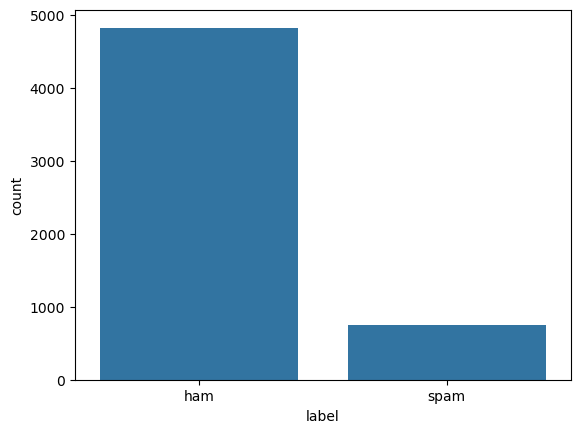

In [185]:
# Plots label counts using a bar chart
sns.countplot(x=df['label'])
plt.show()

In [186]:
# Calculates the number of words (tokens) in each text message
word_counts = [len(text.split()) for text in df['Text']]

# Computes the average number of words per text message
average_word_length = round(sum(word_counts) / len(df['Text']))

# Prints the average number of words
print("Average number of words per text message:", average_word_length)


Average number of words per text message: 16


In [187]:
# Initializes an empty set to store unique words
unique_words = set()

# Loops over each text message in the dataframe
for message in df['Text']:
    # Split the message into words and add to the set of unique words
    unique_words.update(message.split())

# Calculates the total number of unique words in the corpus
total_unique_words = len(unique_words)

# Prints the total number of unique words
print("Total number of unique words in the corpus:", total_unique_words)


Total number of unique words in the corpus: 15686


In [188]:
# Imports necessary library for data splitting
from sklearn.model_selection import train_test_split
import numpy as np

# Converts the 'Text' and 'label_enc' columns to numpy arrays for machine learning processing
X = np.asarray(df['Text'])
y = np.asarray(df['label_enc'])

# Creates a new DataFrame to keep the structure clear and organized
data = pd.DataFrame({'Text': X, 'label': y})

# Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['Text'], data['label'], test_size=0.2, random_state=42)

# Prints the shapes of the resulting train and test datasets to verify correct splits
print("Training data shapes - X:", X_train.shape, "y:", y_train.shape)
print("Testing data shapes - X:", X_test.shape, "y:", y_test.shape)


Training data shapes - X: (4457,) y: (4457,)
Testing data shapes - X: (1115,) y: (1115,)


In [189]:
# Imports necessary libraries for Tfidf vectorization and model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Creates a TfidfVectorizer instance and fit it to the training data
# This vectorizer converts text data into TF-IDF features, suitable for model training
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)  # Fit only to the training data to prevent data leakage

# Transforms both the training and testing data to TF-IDF vectors
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initializes the baseline model using Multinomial Naive Bayes
baseline_model = MultinomialNB()
baseline_model.fit(X_train_tfidf, y_train)

# Predicts labels for the test set using the baseline model
y_pred = baseline_model.predict(X_test_tfidf)

# Evaluates the performance of the baseline model
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

# Prints out the accuracy and the detailed classification report for the baseline model
print("Accuracy of the baseline model:", accuracy)
print("Classification Report:\n", classification_report)


Accuracy of the baseline model: 0.9632286995515695
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.72      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



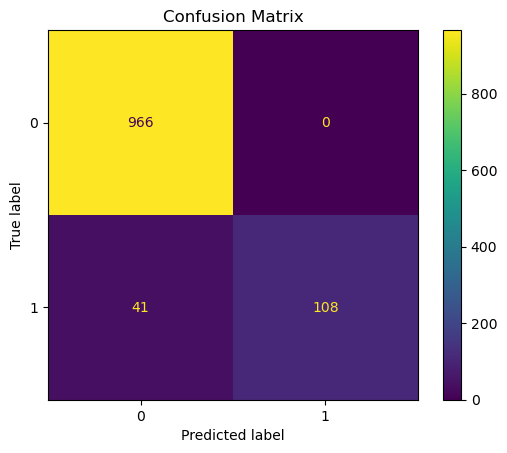

In [190]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gets the confusion matrix data
cm = confusion_matrix(y_test, baseline_model.predict(X_test_tfidf))

# Plots the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_model.classes_)
disp.plot()

# Adds a title and display the plot
import matplotlib.pyplot as plt
plt.title('Confusion Matrix')
plt.show()


In [191]:
from tensorflow.keras.layers import TextVectorization

# Constants for text vectorization
MAXTOKENS = total_unique_words  
OUTPUTLEN = average_word_length  

# Creates a TextVectorization layer to preprocess and convert text data to integer sequences
text_vec = TextVectorization(
    max_tokens=MAXTOKENS,  
    standardize='lower_and_strip_punctuation',  
    output_mode='int',  
    output_sequence_length=OUTPUTLEN 
)

# Adapts the TextVectorization layer to the training data
text_vec.adapt(X_train)

# An Example of using the TextVectorization layer
sample_sentence = "This is a message"
vectorized_output = text_vec([sample_sentence])

# Prints the vectorized output of the sample sentence
print("Vectorized output:", vectorized_output.numpy())


Vectorized output: [[ 41  10   5 148   0   0   0   0   0   0   0   0   0   0   0   0]]


In [192]:
# Defines an embedding layer for a neural network model
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS, 
    output_dim=128,       
    embeddings_initializer='uniform',  
)

In [193]:
# Defines the input layer that accepts strings as input
input_layer = layers.Input(shape=(1,), dtype=tf.string)

# Applies the TextVectorization layer to convert input strings to integer sequences
vec_layer = text_vec(input_layer)

# Applies the Embedding layer to convert integer sequences into dense vectors
embedding_layer_model = embedding_layer(vec_layer)

# Uses Global Average Pooling 1D to reduce the dimensions of the embeddings
x = layers.GlobalAveragePooling1D()(embedding_layer_model)

# Flattens the output of the pooling layer
x = layers.Flatten()(x)

# Adds a dense layer with 32 units and ReLU activation to introduce non-linearity and learn complex patterns
x = layers.Dense(32, activation='relu')(x)

# Outputs layer with a single neuron and sigmoid activation function for binary classification
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Assembles the input and output into a Keras Model
model_1 = keras.Model(inputs=input_layer, outputs=output_layer)

# Compiles the model with the Adam optimizer and binary cross-entropy loss with label smoothing
model_1.compile(
    optimizer='adam', 
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5), 
    metrics=['accuracy']
)


In [194]:
model_1.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 16)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 16, 128)        │     2,007,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,969 (7.68 MB)

 Trainable params: 2,011,969 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

In [195]:
batch_size = 32  # Example batch size
total_samples = len(X_train)  

steps_per_epoch = total_samples // batch_size  
validation_steps = int(0.2 * len(X_test) // batch_size)  # 20% of the test data

history_1 = model_1.fit(
    X_train, y_train,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,  # Optional, as fit() calculates it automatically if not provided
    validation_steps=validation_steps
)


Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8660 - loss: 0.6279 - val_accuracy: 0.9635 - val_loss: 0.5814
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - accuracy: 1.0000 - loss: 0.5631 - val_accuracy: 0.9583 - val_loss: 0.5779
Epoch 3/5
 16/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9905 - loss: 0.5695

C:\Users\Brillar\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9856 - loss: 0.5711 - val_accuracy: 0.9740 - val_loss: 0.5757
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - accuracy: 1.0000 - loss: 0.5636 - val_accuracy: 0.9896 - val_loss: 0.5700
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9916 - loss: 0.5677 - val_accuracy: 0.9844 - val_loss: 0.5720


<Axes: >

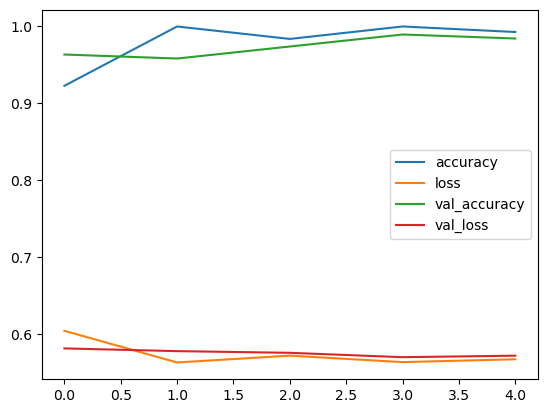

In [196]:
# Converts the history object's history dictionary into a pandas DataFrame
df_history = pd.DataFrame(history_1.history)

# Plots the DataFrame
df_history.plot()

In [197]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compile_model(model):
    ''' 
    Compiles the model with Adam optimizer and binary cross-entropy loss.
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

def evaluate_model(model, X, y):
    ''' 
    Evaluates the model and return a dictionary with accuracy, precision, recall, and f1-score.
    '''
    # Predicts the labels for the dataset
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1
    }
    return model_results_dict

def fit_model(model, epochs, X_train, y_train, X_test=None, y_test=None):
    '''
    Fits the model using the given training data and optionally validate it using test data.
    '''
    if X_test is not None and y_test is not None:
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            validation_data=(X_test, y_test))
    else:
        # If no validation data is provided, fit the model without validation
        history = model.fit(X_train, y_train, epochs=epochs)
    return history

In [198]:
from tensorflow.keras import layers, Model  # Ensure Model is imported correctly# Define the input layer, accepting strings as input
input_layer = layers.Input(shape=(1,), dtype=tf.string)

# Applies the TextVectorization layer to convert text input into integer sequences
vec_layer = text_vec(input_layer)

# Applies the Embedding layer to map integer sequences to dense vectors
embedding_layer_model = embedding_layer(vec_layer)

# Adds a bidirectional LSTM layer with 64 units and tanh activation
bi_lstm = layers.Bidirectional(
    layers.LSTM(64, activation='tanh', return_sequences=True)
)(embedding_layer_model)

# Add another bidirectional LSTM, this time without returning sequences (final output)
lstm = layers.Bidirectional(
    layers.LSTM(64, activation='tanh')
)(bi_lstm)

# Flattens the output to prepare for fully connected layers
flatten = layers.Flatten()(lstm)

# Adds a dropout layer to reduce overfitting
dropout = layers.Dropout(0.1)(flatten)

# Adds a dense layer with 32 units and ReLU activation for further feature learning
x = layers.Dense(32, activation='relu')(dropout)

# Adds the output layer with 1 neuron and sigmoid activation for binary classification
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Creates the model using the input and output layers
model_2 = Model(inputs=input_layer, outputs=output_layer)

# Compiles the model using the previously defined `compile_model` function
compile_model(model_2)

# Trains the model using the `fit_model` function
history_2 = fit_model(
    model_2, 
    epochs=5, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test
)



Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9155 - loss: 0.1910 - val_accuracy: 0.9803 - val_loss: 0.0728
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9977 - loss: 0.0125 - val_accuracy: 0.9785 - val_loss: 0.0883
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9987 - loss: 0.0032 - val_accuracy: 0.9803 - val_loss: 0.0916
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9999 - loss: 3.7868e-04 - val_accuracy: 0.9722 - val_loss: 0.1889
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9821 - val_loss: 0.0886


In [199]:
pip install --upgrade tensorflow tensorflow-hub


Note: you may need to restart the kernel to use updated packages.


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8549 - loss: 0.4673 - val_accuracy: 0.9704 - val_loss: 0.1154
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9746 - loss: 0.0987 - val_accuracy: 0.9776 - val_loss: 0.0719
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9823 - loss: 0.0562 - val_accuracy: 0.9821 - val_loss: 0.0607
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9835 - loss: 0.0559 - val_accuracy: 0.9821 - val_loss: 0.0560
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9845 - loss: 0.0516 - val_accuracy: 0.9812 - val_loss: 0.0549


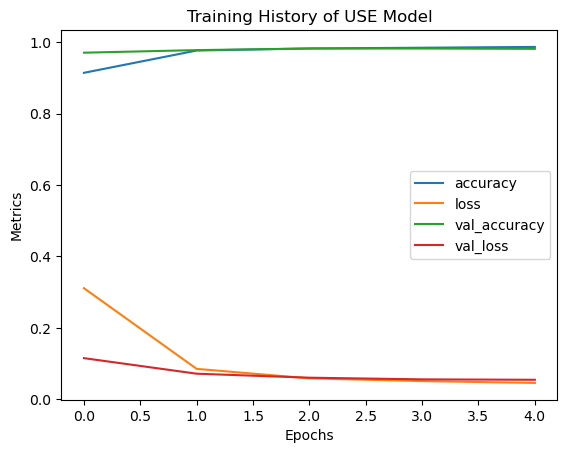

In [200]:
import tensorflow_hub as hub
# Disables XLA compilation for debugging purposes (optional, depending on setup)
tf.config.optimizer.set_jit(False)

# Defines a custom function to compile the model
def compile_model(model):
    """
    Compile the model with Adam optimizer and binary cross-entropy loss.
    """
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

# Defines a custom function to fit the model
def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """
    Train the model with the provided data and epochs.
    """
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_test, y_test),
        batch_size=32
    )
    return history

# Defines the input layer, accepting strings as input
input_layer = keras.Input(shape=[], dtype=tf.string)

# Adds the Universal Sentence Encoder (USE) layer from TensorFlow Hub
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4", 
    trainable=False,  # Pre-trained embeddings are frozen
    input_shape=[], 
    dtype=tf.string, 
    name='USE'
)

# Wraps the USE layer in a Lambda layer for functional API usage
x = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)

# Adds a dropout layer to prevent overfitting
x = layers.Dropout(0.2)(x)

# Adds a dense layer with 64 units and ReLU activation
x = layers.Dense(64, activation=keras.activations.relu)(x)

# Adds the output layer with a single neuron and sigmoid activation for binary classification
output_layer = layers.Dense(1, activation=keras.activations.sigmoid)(x)

# Creates the model using the input and output layers
model_3 = keras.Model(inputs=input_layer, outputs=output_layer)

# Compiles the model
compile_model(model_3)

# Trains the model
history_3 = fit_model(model_3, epochs=5)

# Plots the training history
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history_3.history)
history_df.plot(title='Training History of USE Model')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [201]:
# Compiles the model using a custom function
compile_model(model_3)

# Fits the model using a custom function
history_3 = fit_model(model_3, epochs=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Prints the training history keys to inspect available metrics
print(history_3.history.keys())


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9885 - loss: 0.0397 - val_accuracy: 0.9830 - val_loss: 0.0550
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9883 - loss: 0.0401 - val_accuracy: 0.9830 - val_loss: 0.0538
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9921 - loss: 0.0327 - val_accuracy: 0.9812 - val_loss: 0.0539
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9915 - loss: 0.0248 - val_accuracy: 0.9830 - val_loss: 0.0533
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9925 - loss: 0.0248 - val_accuracy: 0.9839 - val_loss: 0.0543
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [202]:
# Vectorizes X_test for the baseline model (MultinomialNB)
X_test_vec = tfidf_vectorizer.transform(X_test)

# Evaluates each model on the test set and store the results in dictionaries
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)  # For MultinomialNB with vectorized data
model_1_results = evaluate_model(model_1, X_test, y_test)  # For Custom-Vec-Embedding Model
model_2_results = evaluate_model(model_2, X_test, y_test)  # For Bidirectional-LSTM Model
model_3_results = evaluate_model(model_3, X_test, y_test)  # For USE-Transfer learning Model

# Consolidates the results into a DataFrame for comparison
total_results = pd.DataFrame({
    'MultinomialNB Model': baseline_model_results,
    'Custom-Vec-Embedding Model': model_1_results,
    'Bidirectional-LSTM Model': model_2_results,
    'USE-Transfer learning Model': model_3_results
}).transpose()  # Transpose to make models the rows and metrics the columns

# Displays the consolidated results
print(total_results)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
                             accuracy  precision    recall  f1-score
MultinomialNB Model          0.963229   1.000000  0.724832  0.840467
Custom-Vec-Embedding Model   0.977578   0.976923  0.852349  0.910394
Bidirectional-LSTM Model     0.982063   0.970803  0.892617  0.930070
USE-Transfer learning Model  0.983857   0.939597  0.939597  0.939597


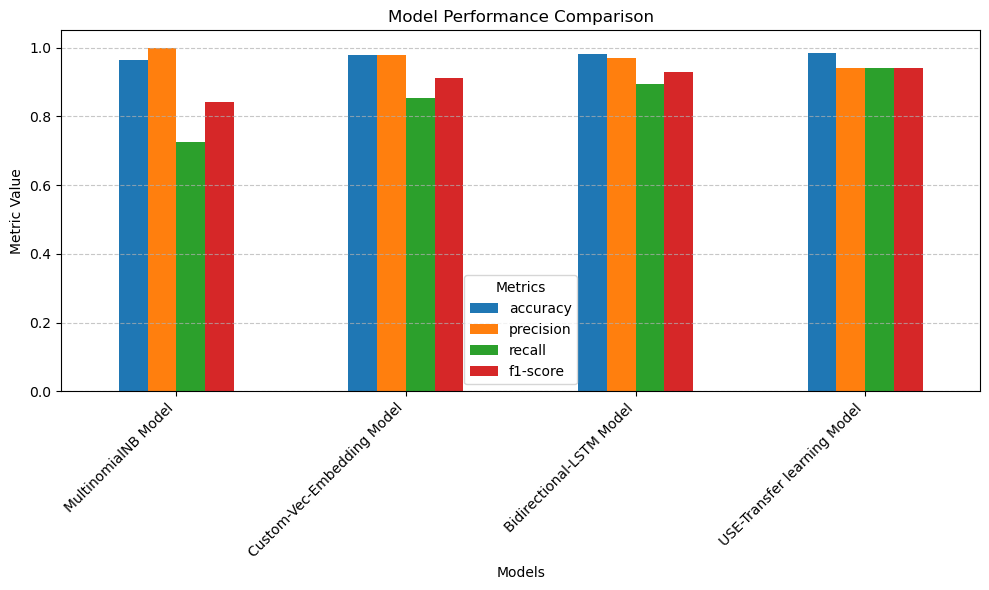

In [222]:
# Plots the results
total_results.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Metric Value')
plt.xlabel('Models')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()